(import_mutations_from_tskit_vignette)=

# Importing mutations from tskit

This vignette shows how to add mutations to a tree sequence
generated by `msprime` and import them into `fwdpy11`.
The key idea is that we add mutations to the tree sequence
using the `fwdpy11` metadata schema.

In [1]:
import msprime
import tskit

ts = msprime.sim_ancestry(1000,
                          recombination_rate=1e-9,
                          sequence_length=1e6,
                          population_size=1000,
                          random_seed=54321)

Get a list of candidate branches:

In [2]:
branch_children = []
branch_left_right = []
branch_derived_mut_freq = []
branch_length_times_span = []

for tree in ts.trees(sample_lists=True):
    for node in tree.nodes():
        parent = tree.parent(node)
        if parent != tskit.NULL:
            ptime = ts.node(parent).time
            ctime = ts.node(node).time
            # We must assign mutations integer-valued
            # times to be compatible with discrete-time
            # forward simulations.  To do so, we filter
            # on branches greater than a generation long.
            if ptime - ctime > 0.0:
                branch_children.append(node)
                branch_left_right.append((tree.interval))
                branch_derived_mut_freq.append(len([i for i in tree.samples(node)])/ts.num_samples)
                branch_length_times_span.append((ptime-ctime)*tree.span)

We will add 10 mutations to our table collection.

First, choose 10 random branches:

In [3]:
import numpy as np
np.random.seed(666 * 42)

branch_weights = np.array(branch_length_times_span)
branch_weights /= np.sum(branch_length_times_span)

chosen_branches = np.random.choice([i for i in range(len(branch_children))], size=10, p=branch_weights)

The next code block specifies parameters for an additive model of mutations affecting a quantitative trait.
The expected heritability (VG) is from theoretical models.
Here, `mu` is the per-genome mutation rate.
(In the literature, this expression is usually written {math}`E[VG] = 2\mu VS`, where {math}`\mu` is the 
*per-individual* mutation rate. Our diploids have two genomes, thus the extra 2.)

In [4]:
VS = 1
mu = 2.5e-4
expectedVG = 4*mu*VS

two_p_q = np.array([2*branch_derived_mut_freq[i]*(1.-branch_derived_mut_freq[i]) for i in chosen_branches])
VG_proportions = 1.0/two_p_q
VG_proportions = VG_proportions/VG_proportions.sum()

Make a copy of the tables to work with:

In [5]:
tables = ts.tables

Add the `fwdpy11` mutation metadata schema:

In [6]:
import fwdpy11

tables.mutations.metadata_schema = fwdpy11.tskit_tools.metadata_schema.MutationMetadata

In [7]:
# We must make sure that mutations
# occur at unique sites because fwdpy11
# is limited to the infinitely-many sites model.
sites = set()
for index, i in enumerate(chosen_branches):
    node = branch_children[i]

    position = np.random.uniform(branch_left_right[i][0], branch_left_right[i][1], 1)[0]
    while position in sites:
        position = np.random.uniform(branch_left_right[i][0], branch_left_right[i][1], 1)[0]
    sites.add(position)

    site = tables.sites.add_row(position, '0')

    p = VG_proportions[index]
    variance_explained = np.random.normal(p * expectedVG, p*(1-p)*expectedVG/2.0)
    effect_size = np.sqrt(variance_explained / two_p_q[index])
    if np.random.uniform(0., 1., 1)[0] < 0.5:
        effect_size *= -1.0

    # Here, we cheat and take the largest integer value >=
    # the node child time.  In production, something else
    # should be done
    time = np.ceil(tables.nodes.time[node])
    print(time, position, effect_size)

    # Build the mutation metadata
    md = {'s': effect_size,
          'h': 1.0,
          'origin': int(time),
          'label': np.uint16(0),
          # NOTE: always write the
          # next 2 lines as shown here.
          # The fwdpy11 back end will do
          # the right thing.
          # A future release will provide a
          # nicer API so that you only need
          # to provide the previous 2 fields.
          'neutral': 0,
          'key': np.uint64(0)
         }
    tables.mutations.add_row(site, node,
                             '1', time=time,
                             metadata=md)

tables.sort()
ts_with_muts = tables.tree_sequence()

1569.0 40493.238231185554 -0.0022386944167888494
40.0 121762.92763238588 0.007960101189896417
556.0 266649.97414862603 0.003763426560000115
1.0 37793.19307550095 0.48489597437771115
54.0 223492.50448300468 -0.02643702612143272
1203.0 240688.67987440425 0.0036802651801063953
71.0 985838.5997973393 0.03060767030455452
65.0 529754.4240739718 0.06128766754803926
40.0 48464.22639751155 -0.011806913348295991
145.0 700935.1474394957 -0.010602752359752003


Create a population and lift over the mutations:

In [8]:
pop = fwdpy11.DiploidPopulation.create_from_tskit(ts_with_muts, import_mutations=True)

Print the number of times each mutation appears in the population and its internal data:

In [9]:
for c, m in zip(pop.mcounts, pop.mutations):
    print(c, "->", m)

3 -> Mutation[position:37793.193076, effect size:0.484896, dominance:1.000000, origin time:-1, label:0]
799 -> Mutation[position:40493.238231, effect size:-0.002239, dominance:1.000000, origin time:-1569, label:0]
144 -> Mutation[position:48464.226398, effect size:-0.011807, dominance:1.000000, origin time:-40, label:0]
144 -> Mutation[position:121762.927632, effect size:0.007960, dominance:1.000000, origin time:-40, label:0]
33 -> Mutation[position:223492.504483, effect size:-0.026437, dominance:1.000000, origin time:-54, label:0]
1206 -> Mutation[position:240688.679874, effect size:0.003680, dominance:1.000000, origin time:-1203, label:0]
688 -> Mutation[position:266649.974149, effect size:0.003763, dominance:1.000000, origin time:-556, label:0]
27 -> Mutation[position:529754.424074, effect size:0.061288, dominance:1.000000, origin time:-65, label:0]
104 -> Mutation[position:700935.147439, effect size:-0.010603, dominance:1.000000, origin time:-145, label:0]
38 -> Mutation[position:9

Our population object does not contain genetic value or fitness information
for the individuals at this stage.
However, under the pure additive model that we are working with,
we can easily check our work from the genomes:

In [10]:
gvalues = []
for i in pop.diploids:
    g = 0.0
    for k in pop.haploid_genomes[i.first].smutations:
        g += pop.mutations[k].s
    for k in pop.haploid_genomes[i.second].smutations:
        g += pop.mutations[k].s
    gvalues.append(g)

gvalues = np.array(gvalues)
print(f"Mean phenotype = {gvalues.mean()},\ninitial VG = {gvalues.var()}.\nDesired initial VG = {expectedVG}")

Mean phenotype = 0.006982417801746341,
initial VG = 0.0008755431852251152.
Desired initial VG = 0.001


Set up a model of additive effects on a phenotype and Gaussian stabilizing
selection with an optimum of 1 and the (inverse) strength of stabilizing
selection is also 10.0.

::: {note}
Pay attention to the recombination rate here: it is per genome in `fwdpy11`
but per "base pair" in `msprime`!
:::

In [11]:
pdict = {'nregions': [], 'sregions': [],
         'recregions': [fwdpy11.PoissonInterval(0, pop.tables.genome_length,
                                                1e-9*pop.tables.genome_length)],
         'rates': (0., 0., None),
         'gvalue': fwdpy11.Additive(scaling=2, 
                                     gvalue_to_fitness=fwdpy11.GSS(optimum=1.0, VS=1.0)),
         'simlen': 100,
         'demography': fwdpy11.DiscreteDemography(),
         'prune_selected': False
         }
params = fwdpy11.ModelParams(**pdict)

Set up recording some data:

In [12]:
from dataclasses import dataclass

@dataclass
class SimData:
    generation: int
    mean_phenotype: float
    mean_fitness: float

@dataclass
class Recorder:
    data: list

    def __call__(self, pop, _):
        md = np.array(pop.diploid_metadata)
        mean_pheno = md['g'].mean()
        mean_fitness = md['w'].mean()
        self.data.append(SimData(pop.generation, mean_pheno, mean_fitness))

Run the simulation:

In [13]:
rng = fwdpy11.GSLrng(2351235)
recorder = Recorder(data = [])
fwdpy11.evolvets(rng, pop, params, simplification_interval=50,
                 recorder=recorder, suppress_table_indexing=True)
assert pop.generation == 100

Plot our results:

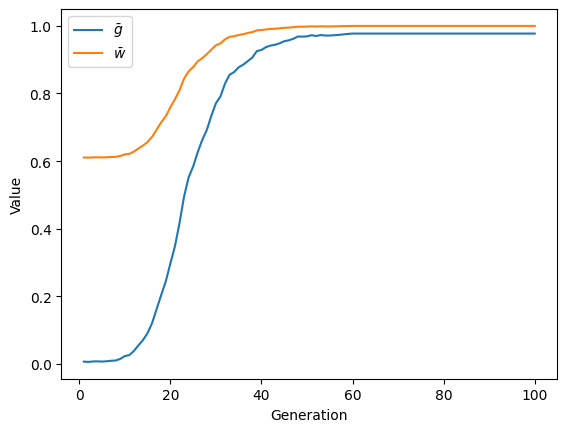

In [14]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
g = [i.generation for i in recorder.data]
p = [i.mean_phenotype for i in recorder.data]
w = [i.mean_fitness for i in recorder.data]
ax.plot(g, p, label=r'$\bar{g}$')
ax.plot(g, w, label=r'$\bar{w}$')
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.legend(loc='best');

What mutations are left at the end of the sim?

In [15]:
for c, m in zip(pop.mcounts, pop.mutations):
    print(c, "->", m)

2000 -> Mutation[position:37793.193076, effect size:0.484896, dominance:1.000000, origin time:-1, label:0]
2000 -> Mutation[position:240688.679874, effect size:0.003680, dominance:1.000000, origin time:-1203, label:0]
